In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse import csr_matrix, lil_matrix
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#support methods

catagories = ["0.033","0.066","0.1","0.133",'0.142',"0.166","0.2","0.233","0.266",'0.285',"0.3","0.333",'0.428',"0.5",'0.571','0.714','0.857',"1/7", "2/7", "3/7",
                  "4/7", "5/7", "6/7", "1", "2", "3", "3.5", "4",'4.8', "6", "6.857", "8", "9","9.6", "10", "11", "12", 
       "13", "14","14.4", "15", "16", "17", "18", "19",'19.2', "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30"
      ,"24/5", "48/5", "72/5", "96/5", "1/2"]
def valueToCatagoryIndex(y):

    newY = y.copy()
    for i in range(y.size):
        for j in range(len(catagories)):
            if catagories[j] == y[i]:
                newY[i] = j
    return newY

def catagoryToValue(y):
    print(y)
    newY = y.copy()
    for i in range(len(y)):
        newY[i] = catagories[y[i]]
    return newY

def preprocessText(X):
    stemmer = WordNetLemmatizer()
    print(stemmer)
    list_of_str = []
    train_and_test = []
    for i in range(len(X)):
        # Remove all the special characters
        current_str = re.sub(r'\W', ' ', str(X[i]))

        # Remove all () brackets and their contents
        current_str = re.sub("[\(\[].*?[\)\]]", " ", current_str)

        # remove all single characters
        current_str = re.sub(r'\s+[a-zA-Z]\s+', ' ', current_str)

        # Lemmatization
        current_str = current_str.split()

        current_str = [stemmer.lemmatize(word) for word in current_str]
        current_str = ' '.join(current_str)

        list_of_str.append(current_str)

    return list_of_str

#Method to increase the weight of words found in multiple sentences
def reverseIDF(X_counts, count_vect):
    #IDF = log(N/n)
    #rIDF = current * (1 + n/N)

    #amount of documents
    N = X_counts.shape[0]
    X_ridf = lil_matrix(X_counts, dtype=float)

    index = 0
    while index in count_vect.vocabulary_.values():
        count = 0
        indexOfMatches = []
        for i in range(N):
            if X_counts[i,index] != 0:
                indexOfMatches.append(i)
                count +=1
        #n is amount of documents this word is found in
        n = count
        for i in range(len(indexOfMatches)):
            current = X_counts[i,index]
            X_ridf[i,index] = current * (1 + n/N)
        index += 1
    
    return X_ridf

def train_model(classifier, trainingX, trainingY, testingX, testingY):
    # fit the training dataset on the classifier
    classifier.fit(trainingX, trainingY)
    

    predictions = classifier.predict(testingX)
    mean_squared = metrics.mean_squared_error(list(map(float, testingY)), list(map(float, predictions)))


    plot_classification_report(metrics.classification_report(testingY,predictions, zero_division=0),number_of_classes = testingY.shape[0])


    return classifier, metrics.accuracy_score(predictions, testingY), mean_squared   


def plot(trained_model, X_train_vect, y_train, X_test_vect, y_test, X_test, title):
    
    y_true = list(map(float, y_test))
    y_predicted = list(map(float, trained_model.predict(X_test_vect)))

    mismatch_string = []
    mismatch_y_predicted = []
    mismatch_y_true = []

    for i in range(len(y_predicted)):
        if y_predicted[i] != y_true[i]: 
            mismatch_string.append(X_test[i])  
            mismatch_y_predicted.append(y_predicted[i])
            mismatch_y_true.append(y_true[i])

    fig, ax = plt.subplots()
    scatter = ax.scatter(mismatch_string, mismatch_y_true, c='g')
    marker = itertools.cycle(('s', '+', '.', 'o', '*','h','H'))
    #create a new scatterplot for each y_predicted so they are all added to the legend
    for i in range(len(mismatch_string)): 
        ax.scatter(mismatch_string[i], mismatch_y_predicted[i], c='r',marker=next(marker) ,s=50)
    
    ax.set_xticks(np.arange(len(X_test)))
    ax.set_xticklabels(np.arange(len(X_test)))
    fig.set_figwidth(8)
    plt.grid()
    ax.set_title(title)
    ax.margins(x=0.025, y=0.05)
    
    mismatch_string.insert(0,"True Value")#first legend value

    ax.legend(mismatch_string, title="Classes", loc="upper left", bbox_to_anchor=(1,1))
    plt.show()



def plotAccuracies(accs, Xval = None, title = "title", yLab = None, ax = plt, accs2 = None, legends=None):
    if Xval == None:
        Xval = ["Base", "Preprocessed", "TF-IDF", "Prep TF-IDF", "Reverse", "Prep Reverse"]
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)
        
    ax.grid()
    plt.ylabel(yLab, fontsize=16)
    marker = itertools.cycle(('ro', 'bo', 'go' , 'yo', 'mo', 'co'))
    ax.plot(Xval, accs, 'k')
    
    if accs2 != None:
        ax.plot(Xval, accs2, 'r')
        for i, acc in enumerate(accs2):
            ax.plot(Xval[i], acc, next(marker))
            
    for i, acc in enumerate(accs):
        ax.plot(Xval[i], acc, next(marker))
        
    if legends != None:
            ax.legend(legends)

    

In [3]:
#code block from: https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.05)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, number_of_classes=2, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    #drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)


    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 8
    figure_height = len(class_names)/2.5 + 3
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.show()

In [4]:
train = np.loadtxt('completeX.txt', dtype=np.str, delimiter="|")
target = np.loadtxt('completeY.txt', dtype=np.str, delimiter='|')
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=0)
# y_train = valueToCatagoryIndex(y_train)
# y_test = valueToCatagoryIndex(y_test)

# y_test = list(map(float, y_test))
# y_train = list(map(float, y_train))
# print(type(y_test))


train_preprocess = preprocessText(train)
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(train_preprocess, 
                                                                    target, test_size=0.3, random_state=0)
# y_train_pre = valueToCatagoryIndex(y_train_pre)
# y_test_pre = valueToCatagoryIndex(y_test_pre)
# label encode the target variable 
# encoder = preprocessing.LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_test = encoder.fit_transform(y_test)

<WordNetLemmatizer>


In [5]:
# Stop words preprocessing
customStopWords = ["take", "tablet","capsule", "inhale", "inhalation", "puff", "instill", "insert", "drop", "both",
                  "right", "left"]





# Count vectorizer for tf-idf
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train)
X_train_counts = count_vect.transform(X_train)
X_test_counts = count_vect.transform(X_test)


# String preprocessing and vectorize with preprocessed text
count_vect_preprocess = CountVectorizer(max_features=50, min_df=5, max_df=0.4, stop_words=customStopWords)
count_vect_preprocess.fit(train_preprocess)
X_train_counts_pre = count_vect_preprocess.transform(X_train_pre)
X_test_counts_pre = count_vect_preprocess.transform(X_test_pre)

# Tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

# Tf-idf preprocessed
X_train_pre_tfidf = tfidf_transformer.fit_transform(X_train_counts_pre)
X_test_pre_tfidf = tfidf_transformer.fit_transform(X_test_counts_pre)

# Reverse IDF
X_train_ridf = reverseIDF(X_train_counts, count_vect)
X_test_ridf = reverseIDF(X_test_counts, count_vect)

# Reverse idf preprocessed
X_train_pre_ridf = reverseIDF(X_train_counts_pre, count_vect_preprocess)
X_test_pre_ridf = reverseIDF(X_test_counts_pre, count_vect_preprocess)

<WordNetLemmatizer>


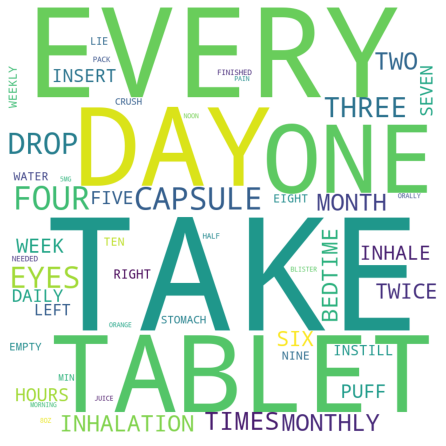

In [6]:
#Code to plot a wordcloud for the frequency of words in dataset
trainlist = train.tolist()

prep = preprocessText(trainlist)

for i in range(len(prep)):
    prep[i] = prep[i] + " "
res = ''.join(prep)


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10,
                collocations=False).generate(res)
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


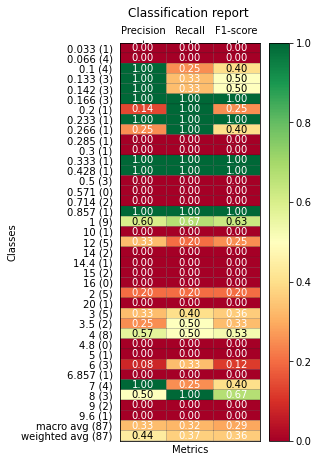

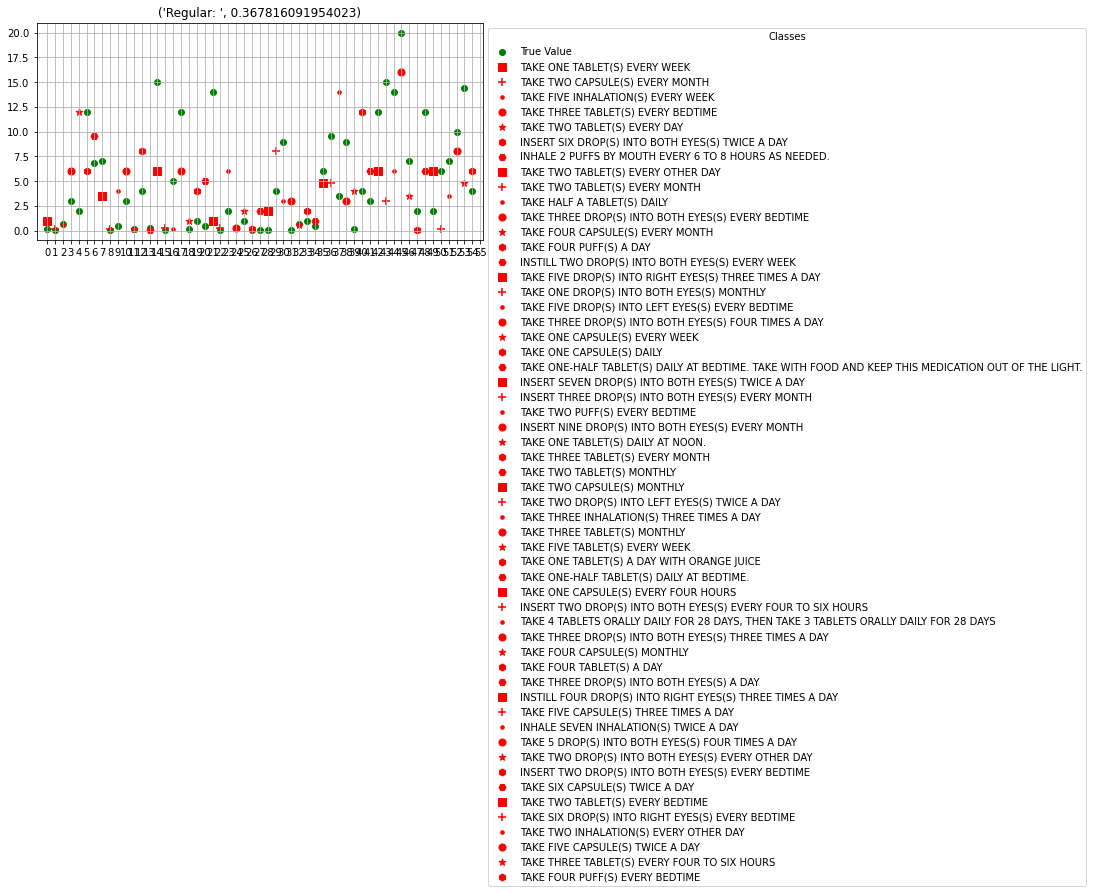

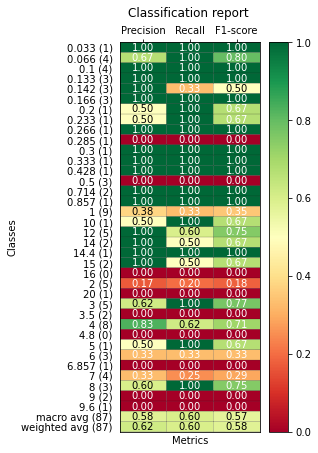

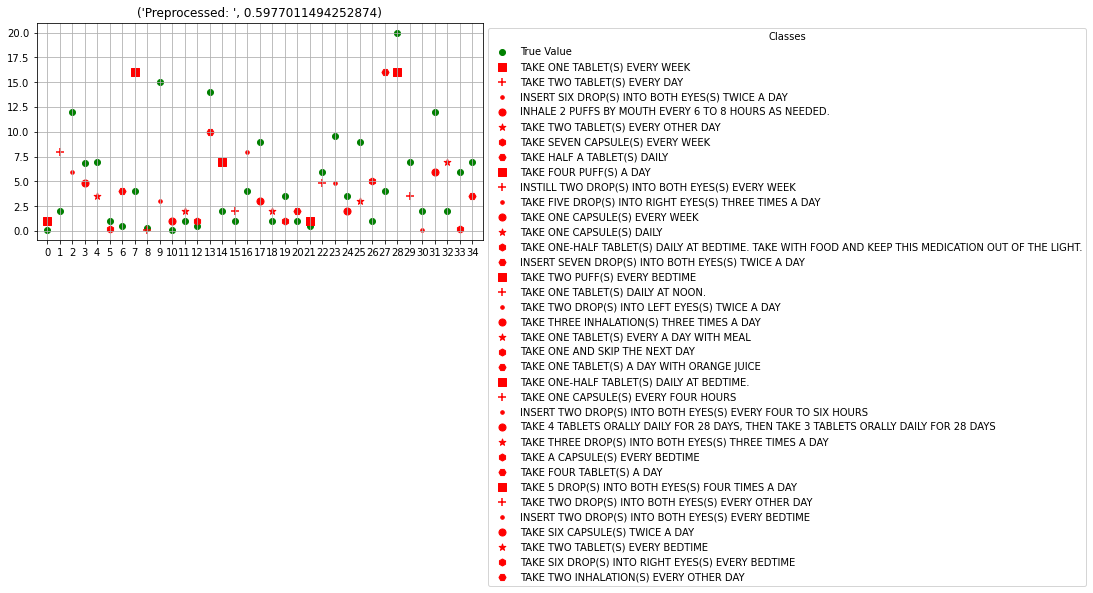

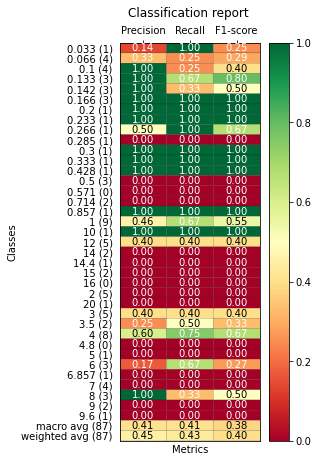

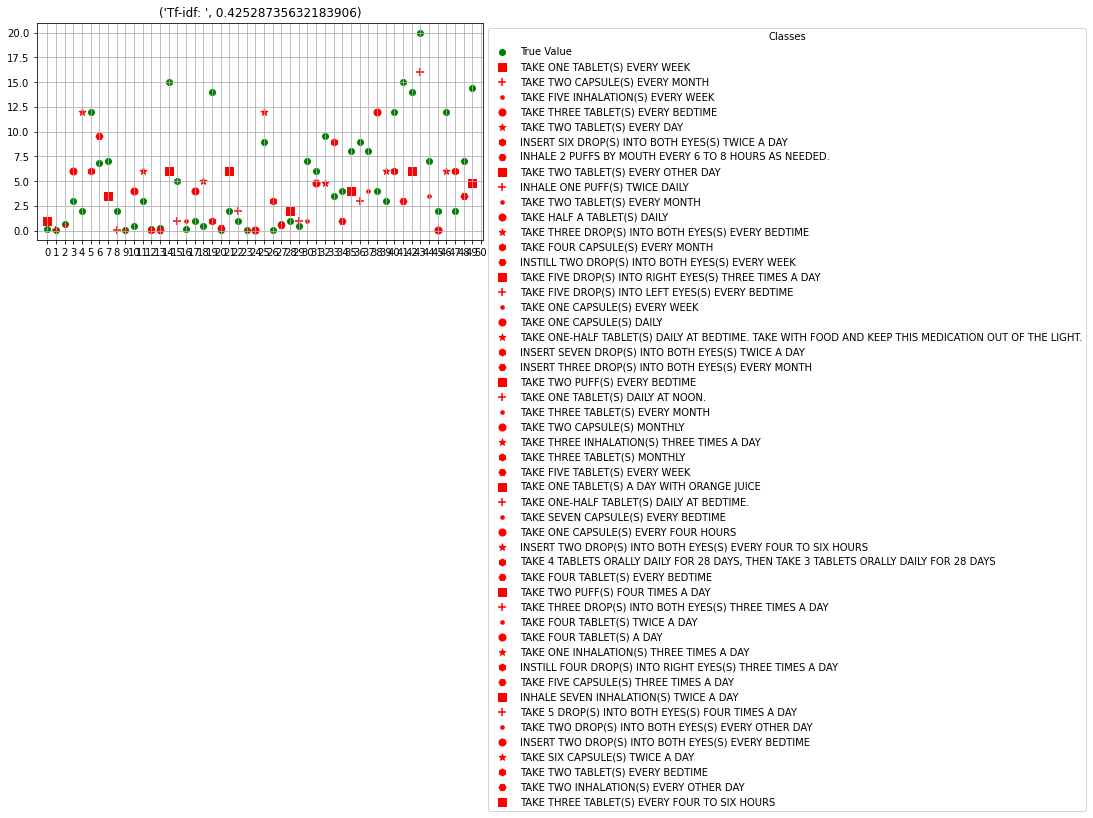

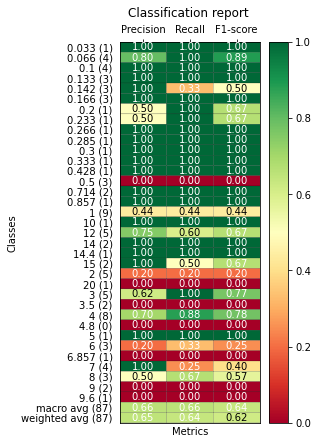

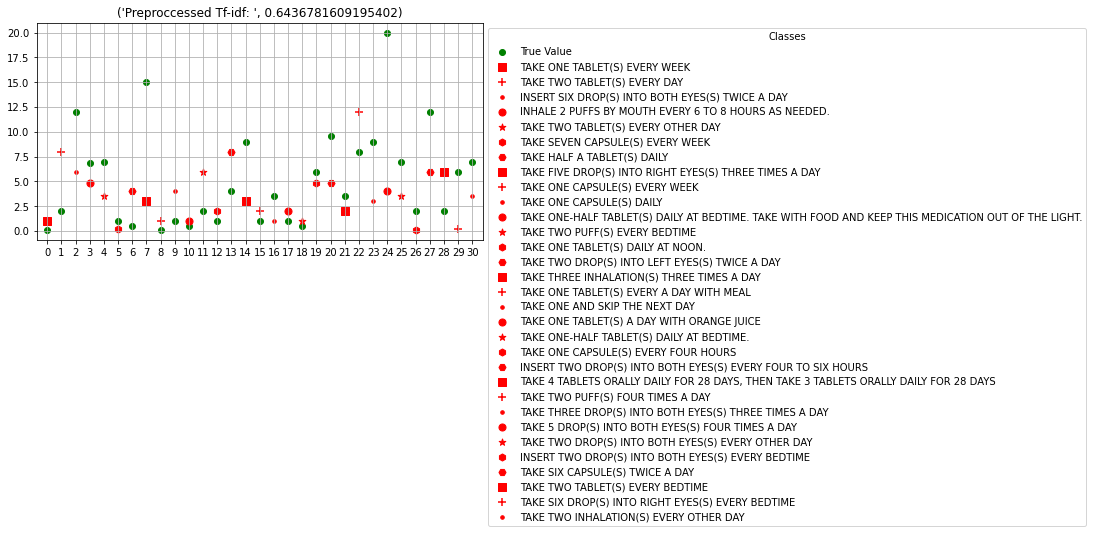

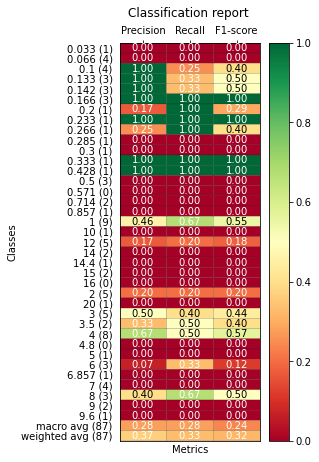

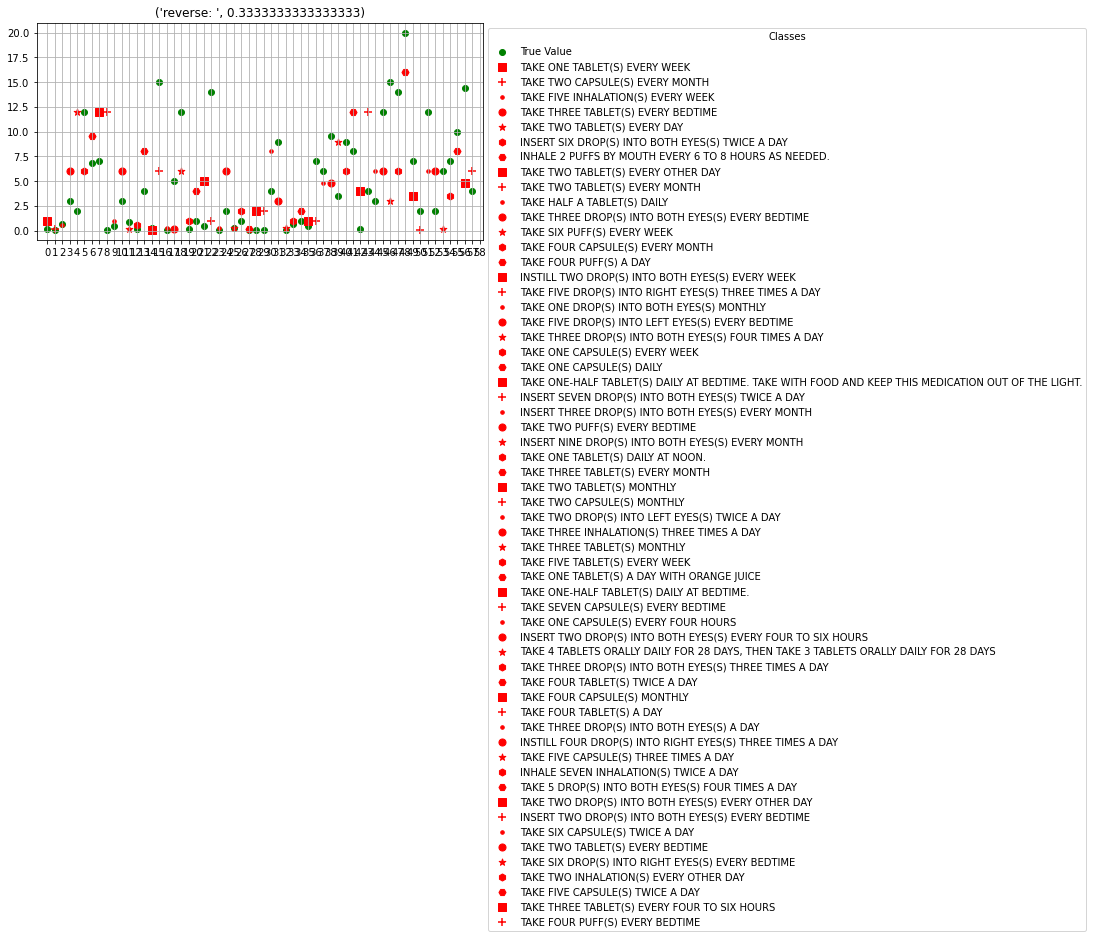

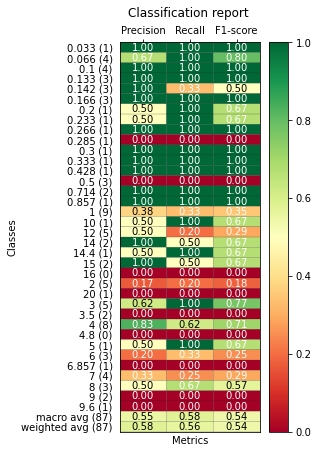

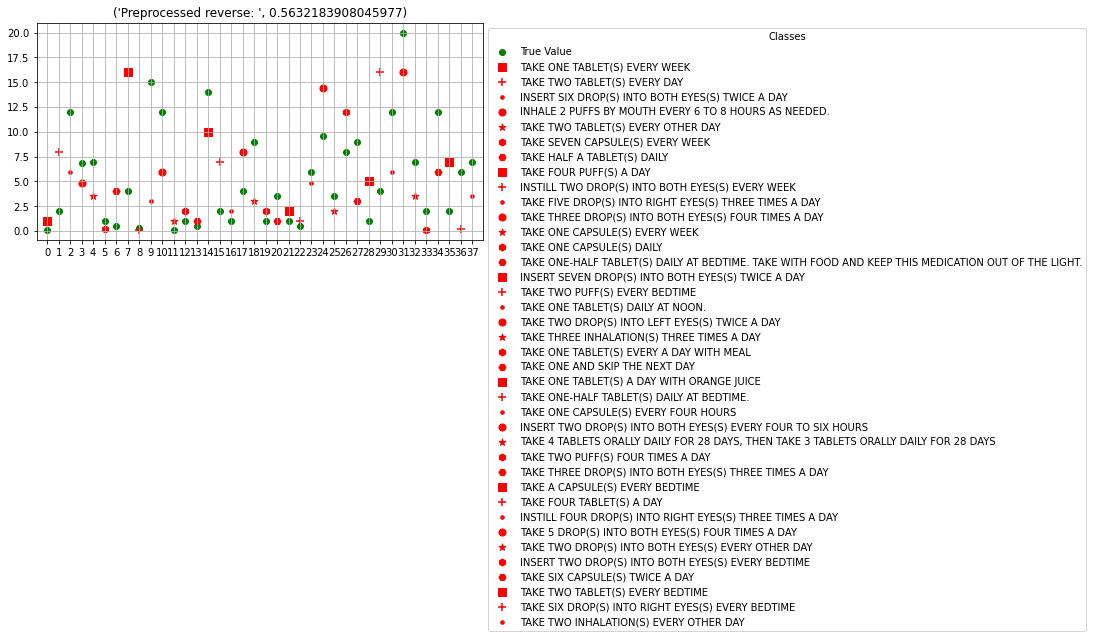

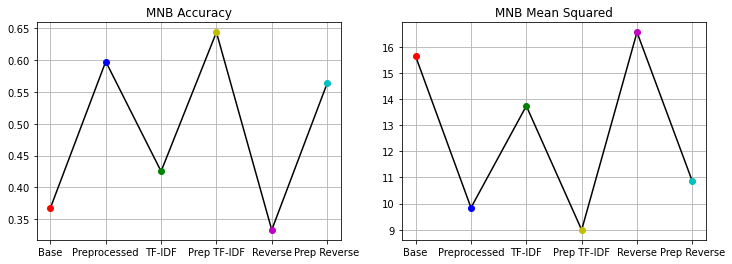

In [7]:
#constants
DEFAULT = 0
PREP = 1
TFIDF = 2
PREPTFIDF = 3
REVERSE = 4
PREPREVERSE =5
#Using Multinomial Naive Bayes clf

NBs = [None] * 6
NBAccs = [None] * 6
NBMeanSquared = [None] * 6
MBN = MultinomialNB(alpha = 0.5, fit_prior = False)

#Baseline Multinomial Naive Bayes
NBs[DEFAULT], NBAccs[DEFAULT], NBMeanSquared[DEFAULT] = train_model(MBN, X_train_counts, y_train, X_test_counts, y_test)
MBNT = "Regular: ", NBAccs[DEFAULT]
plot(NBs[DEFAULT], X_train_counts, y_train, X_test_counts, y_test, X_test, MBNT)

#Multinomial Naive Bayes with Preprocessing
NBs[PREP], NBAccs[PREP], NBMeanSquared[PREP] = train_model(MBN, X_train_counts_pre, y_train, X_test_counts_pre, y_test)
pre_NBT = "Preprocessed: ", NBAccs[PREP]
plot(NBs[PREP], X_train_counts_pre, y_train, X_test_counts_pre, y_test, X_test, pre_NBT)


#Multinomial Naive Bayes using tf-idf
NBs[TFIDF], NBAccs[TFIDF], NBMeanSquared[TFIDF] = train_model(MBN, X_train_tfidf, y_train, X_test_tfidf, y_test)
tfidf_NBT = "Tf-idf: ", NBAccs[TFIDF]
plot(NBs[TFIDF], X_train_tfidf, y_train, X_test_tfidf, y_test, X_test, tfidf_NBT)

#Multinomial Naive Bayes using tf-idf with Preprocessing
NBs[PREPTFIDF], NBAccs[PREPTFIDF], NBMeanSquared[PREPTFIDF] = train_model(MBN, X_train_pre_tfidf, y_train, X_test_pre_tfidf, y_test)
tfidf_pre_NBT = "Preproccessed Tf-idf: ", NBAccs[PREPTFIDF]
plot(NBs[PREPTFIDF], X_train_pre_tfidf, y_train, X_test_pre_tfidf, y_test, X_test, tfidf_pre_NBT)


#Multinomial Naive Bayes using reverse tf-idf
NBs[REVERSE], NBAccs[REVERSE], NBMeanSquared[REVERSE] = train_model(MBN, X_train_ridf, y_train, X_test_ridf, y_test)
reverse_NBT = "reverse: ", NBAccs[REVERSE]
plot(NBs[REVERSE], X_train_ridf, y_train, X_test_ridf, y_test, X_test, reverse_NBT)

#Multinomial Naive Bayes using reverse tf-idf with Preprocessing
NBs[PREPREVERSE], NBAccs[PREPREVERSE], NBMeanSquared[PREPREVERSE] = train_model(MBN, X_train_pre_ridf, y_train, X_test_pre_ridf, y_test)
reverse_pre_NBT = "Preprocessed reverse: ", NBAccs[PREPREVERSE]
plot(NBs[PREPREVERSE], X_train_pre_ridf, y_train, X_test_pre_ridf, y_test, X_test, reverse_pre_NBT)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)

plotAccuracies(NBAccs, title = "MNB Accuracy", ax=ax1)
plotAccuracies(NBMeanSquared, title = "MNB Mean Squared", ax=ax2)

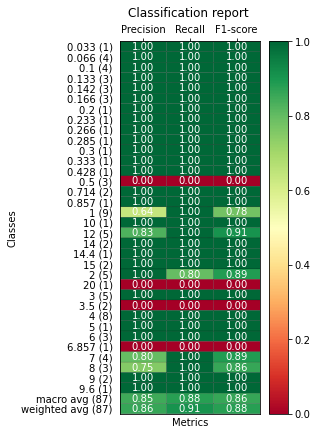

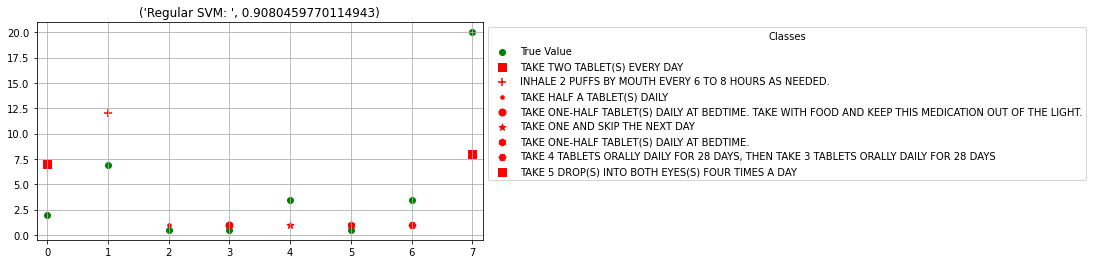

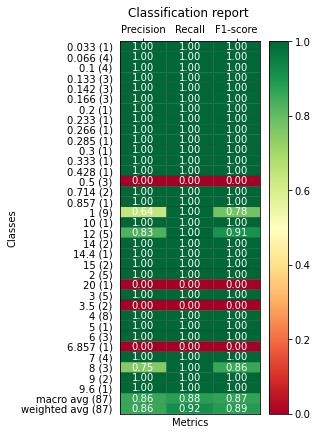

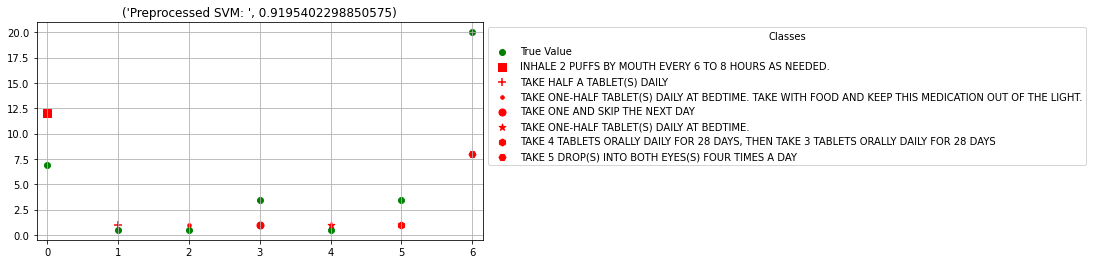

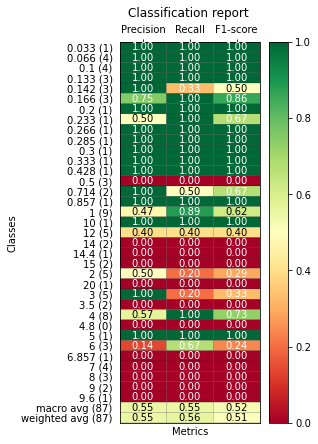

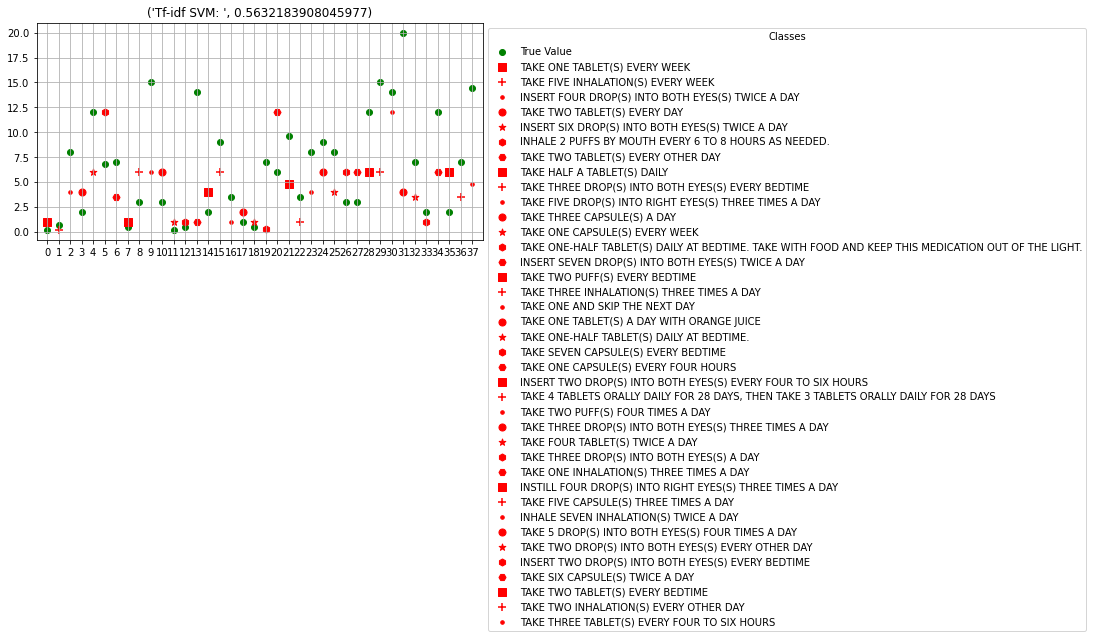

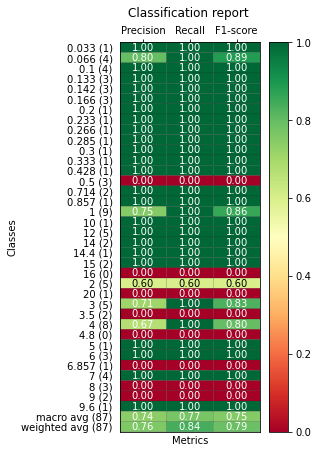

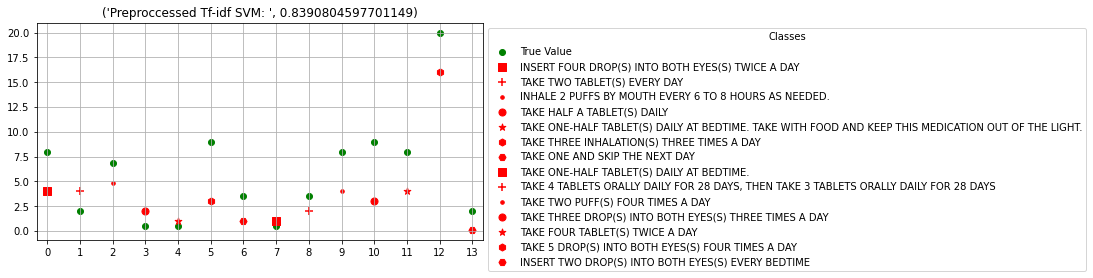

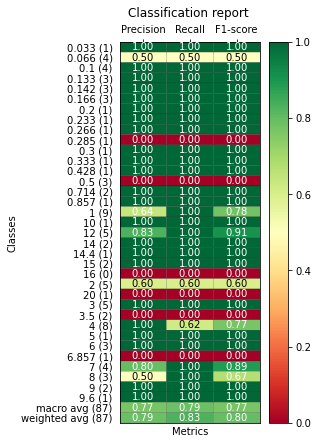

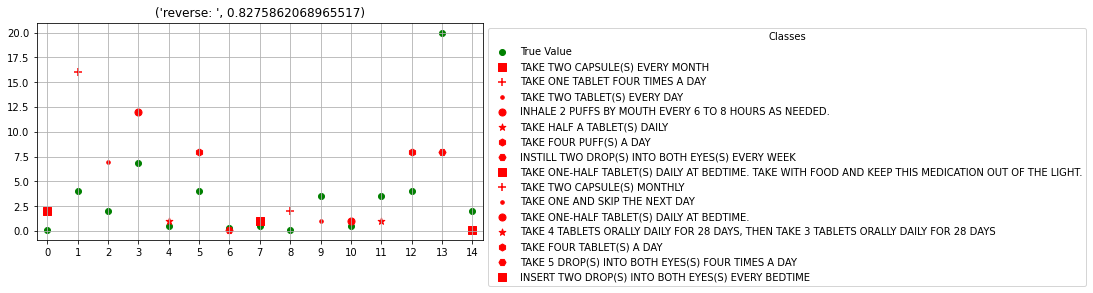

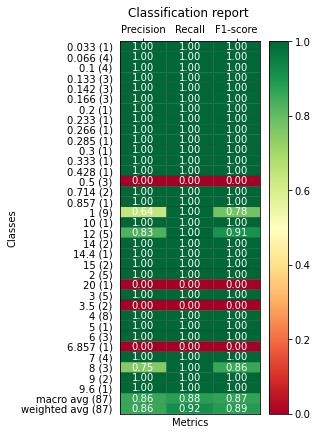

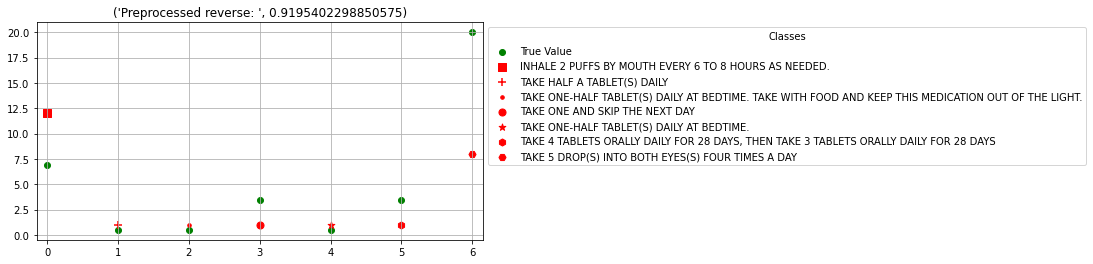

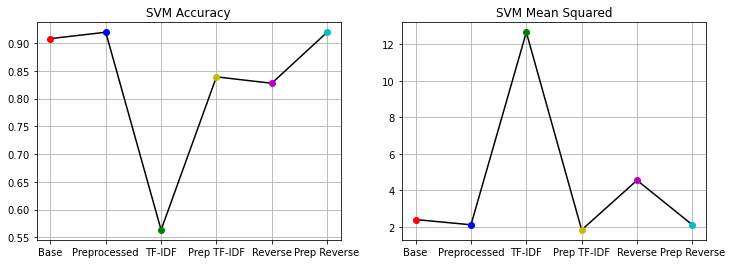

In [8]:
#Support Vector Machine Classifier

SVMs = [None] * 6
SVMAccs = [None] * 6
SVMMeanSquared = [None] * 6

svc = SVC(kernel='sigmoid',C=130, gamma='auto', probability = True, random_state = 1)

#Baseline Support Vector Machine Classifier
SVMs[DEFAULT], SVMAccs[DEFAULT], SVMMeanSquared[DEFAULT] = train_model(svc, X_train_counts, y_train, X_test_counts, y_test)
SVMT = "Regular SVM: ", SVMAccs[DEFAULT]
plot(SVMs[DEFAULT], X_train_counts, y_train, X_test_counts, y_test, X_test, SVMT)

#Support Vector Machine Classifier with Preprocessing
SVMs[PREP], SVMAccs[PREP], SVMMeanSquared[PREP] = train_model(svc, X_train_counts_pre, y_train, X_test_counts_pre, y_test)
pre_SVMT = "Preprocessed SVM: ", SVMAccs[PREP]
plot(SVMs[PREP], X_train_counts_pre, y_train, X_test_counts_pre, y_test, X_test, pre_SVMT)


#Support Vector Machine Classifier using tf-idf
SVMs[TFIDF], SVMAccs[TFIDF], SVMMeanSquared[TFIDF] = train_model(svc, X_train_tfidf, y_train, X_test_tfidf, y_test)
tfidf_SVMT = "Tf-idf SVM: ", SVMAccs[TFIDF]
plot(SVMs[TFIDF], X_train_tfidf, y_train, X_test_tfidf, y_test, X_test, tfidf_SVMT)

#Support Vector Machine Classifier using tf-idf with Preprocessing
SVMs[PREPTFIDF], SVMAccs[PREPTFIDF], SVMMeanSquared[PREPTFIDF] = train_model(svc, X_train_pre_tfidf, y_train, X_test_pre_tfidf, y_test)
tfidf_pre_SVMT = "Preproccessed Tf-idf SVM: ", SVMAccs[PREPTFIDF]
plot(SVMs[PREPTFIDF], X_train_pre_tfidf, y_train, X_test_pre_tfidf, y_test, X_test, tfidf_pre_SVMT)


#Support Vector Machine Classifier using reverse tf-idf
SVMs[REVERSE], SVMAccs[REVERSE], SVMMeanSquared[REVERSE] = train_model(svc, X_train_ridf, y_train, X_test_ridf, y_test)
reverse_SVMT = "reverse: ", SVMAccs[REVERSE]
plot(SVMs[REVERSE], X_train_ridf, y_train, X_test_ridf, y_test, X_test, reverse_SVMT)

#Support Vector Machine Classifier using reverse tf-idf with Preprocessing
SVMs[PREPREVERSE], SVMAccs[PREPREVERSE], SVMMeanSquared[PREPREVERSE] = train_model(svc, X_train_pre_ridf, y_train,X_test_pre_ridf, y_test)
reverse_pre_SVMT = "Preprocessed reverse: ", SVMAccs[PREPREVERSE]
plot(SVMs[PREPREVERSE], X_train_pre_ridf, y_train, X_test_pre_ridf, y_test, X_test, reverse_pre_SVMT)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)

plotAccuracies(SVMAccs, title = "SVM Accuracy", ax=ax1)
plotAccuracies(SVMMeanSquared, title = "SVM Mean Squared", ax=ax2)

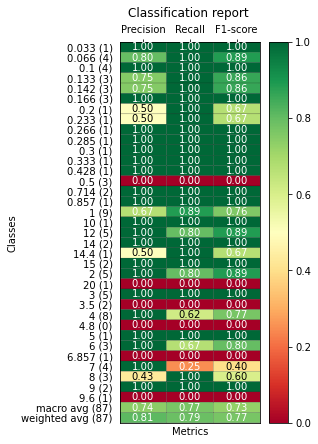

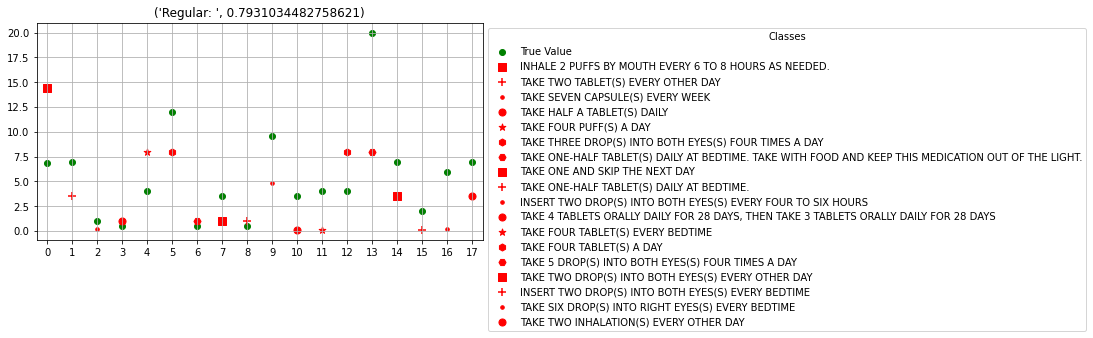

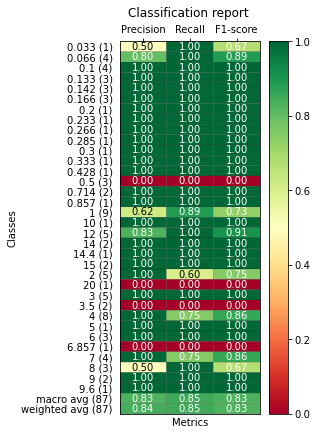

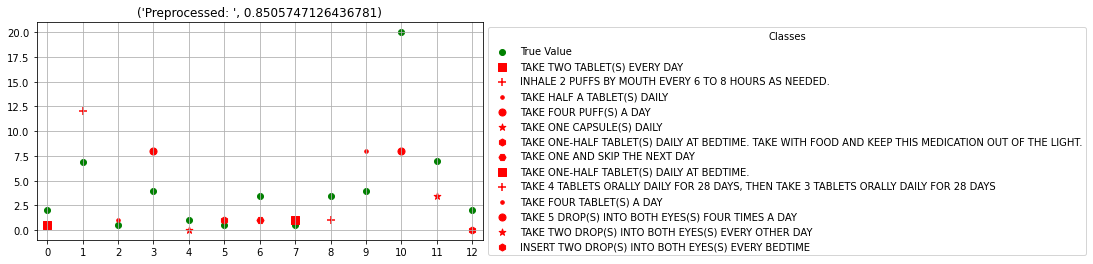

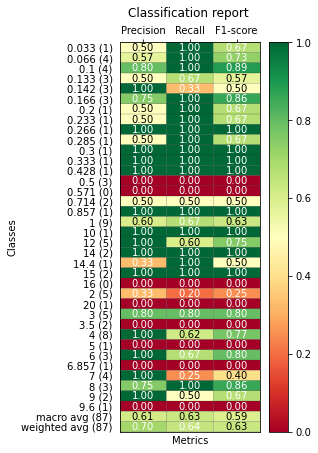

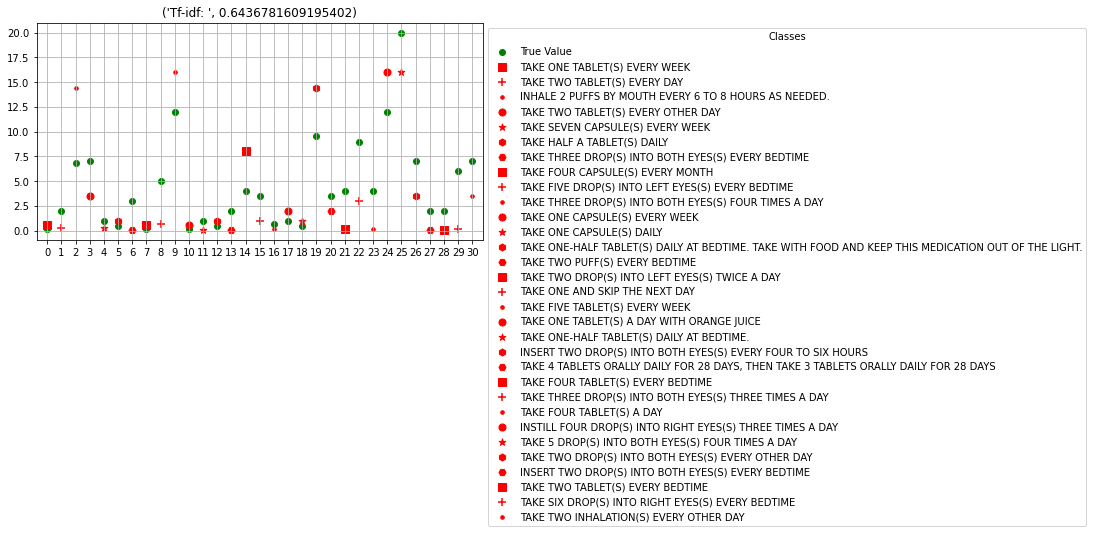

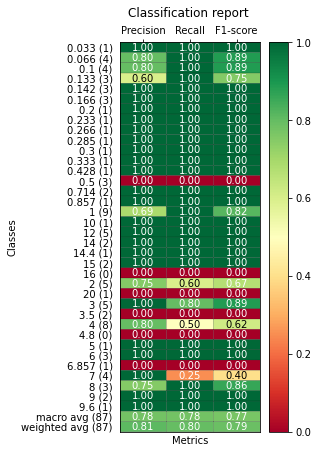

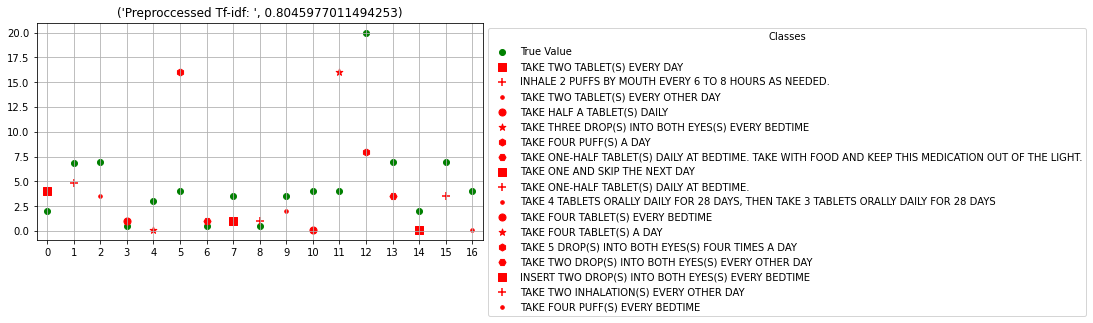

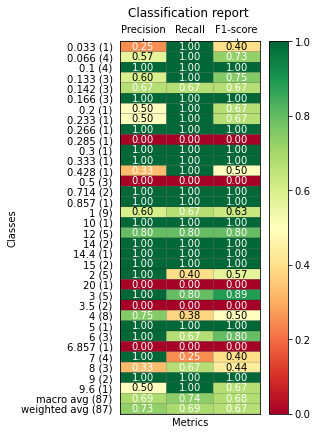

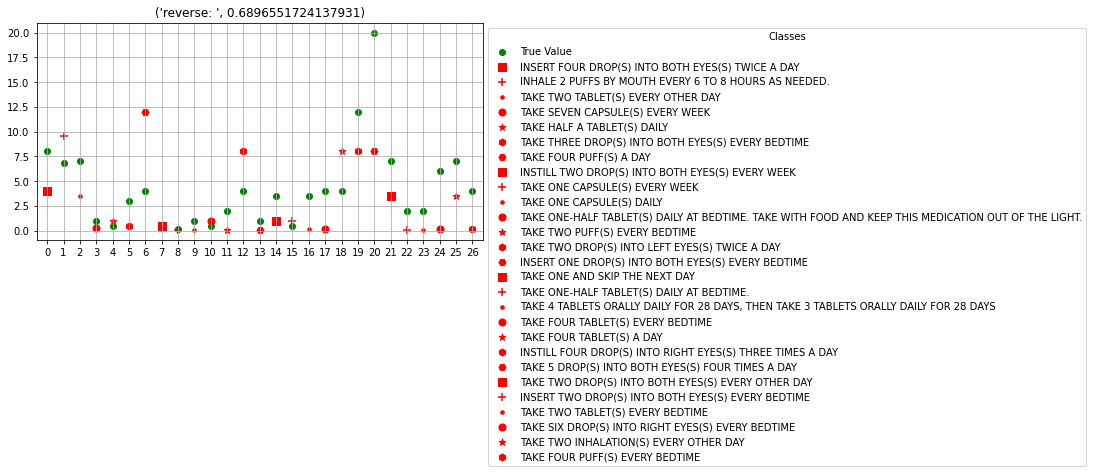

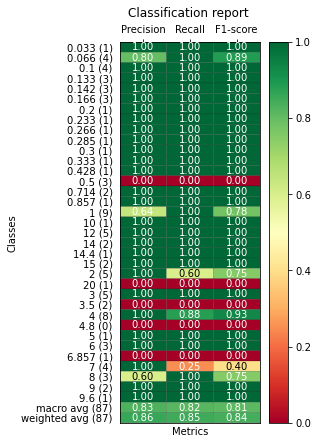

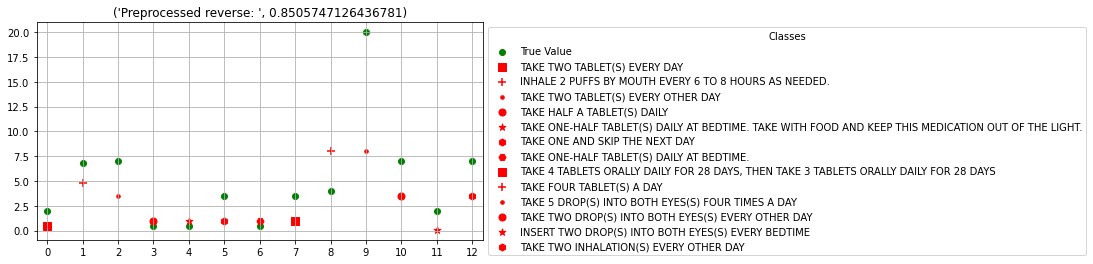

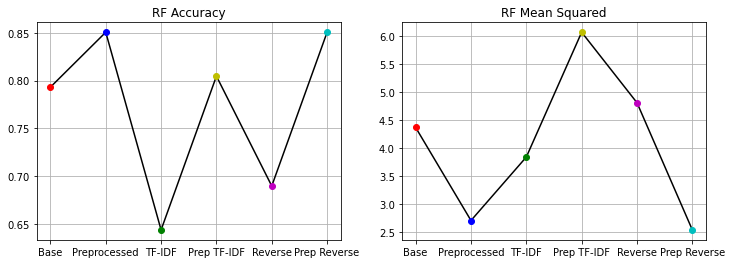

In [9]:
# Random Forest CLF
RFs = [None] * 6
RFAccs = [None] * 6
RFMeanSquared = [None] * 6

RF = RandomForestClassifier(ccp_alpha=0, class_weight='balanced', criterion='gini', max_depth=150, max_features='auto',
                           max_leaf_nodes=50,min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=6,
                           min_weight_fraction_leaf=0, n_estimators=100, random_state=1)
#Baseline Random Forest
RFs[DEFAULT], RFAccs[DEFAULT], RFMeanSquared[DEFAULT] = train_model(RF, X_train_counts, y_train, X_test_counts, y_test)
RFT = "Regular: ", RFAccs[DEFAULT]
plot(RFs[DEFAULT], X_train_counts, y_train, X_test_counts, y_test, X_test, RFT)

#Random Forest with Preprocessing
RFs[PREP], RFAccs[PREP], RFMeanSquared[PREP] = train_model(RF, X_train_counts_pre, y_train, X_test_counts_pre, y_test)
pre_RFT = "Preprocessed: ", RFAccs[PREP]
plot(RFs[PREP], X_train_counts_pre, y_train, X_test_counts_pre, y_test, X_test, pre_RFT)


#Random Forest using tfidf
RFs[TFIDF], RFAccs[TFIDF], RFMeanSquared[TFIDF] = train_model(RF, X_train_tfidf, y_train, X_test_tfidf, y_test)
tfidf_RFT ="Tf-idf: ", RFAccs[TFIDF]
plot(RFs[TFIDF], X_train_tfidf, y_train, X_test_tfidf, y_test, X_test, tfidf_RFT)

#Random Forest using tfidf with Preprocessing
RFs[PREPTFIDF], RFAccs[PREPTFIDF], RFMeanSquared[PREPTFIDF] = train_model(RF, X_train_pre_tfidf, y_train, X_test_pre_tfidf, y_test)
tfidf_pre_RFT ="Preproccessed Tf-idf: ", RFAccs[PREPTFIDF]
plot(RFs[PREPTFIDF], X_train_pre_tfidf, y_train, X_test_pre_tfidf, y_test, X_test, tfidf_pre_RFT)


#Random Forest using reverse tfidf
RFs[REVERSE], RFAccs[REVERSE], RFMeanSquared[REVERSE] = train_model(RF, X_train_ridf, y_train, X_test_ridf, y_test)
ridf_RFT ="reverse: ", RFAccs[REVERSE]
plot(RFs[REVERSE], X_train_ridf, y_train, X_test_ridf, y_test, X_test, ridf_RFT)

#Random Forest using reverse tfidf with Preprocessing
RFs[PREPREVERSE], RFAccs[PREPREVERSE], RFMeanSquared[PREPREVERSE] = train_model(RF, X_train_pre_ridf, y_train, X_test_pre_ridf, y_test)
ridf_pre_RFT= "Preprocessed reverse: ", RFAccs[PREPREVERSE]
plot(RFs[PREPREVERSE], X_train_pre_ridf, y_train, X_test_pre_ridf, y_test, X_test, ridf_pre_RFT)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)

plotAccuracies(RFAccs, title = "RF Accuracy", ax=ax1)
plotAccuracies(RFMeanSquared, title = "RF Mean Squared", ax=ax2)

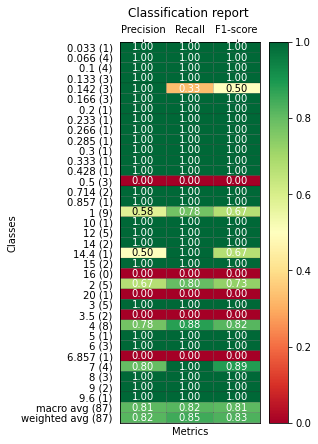

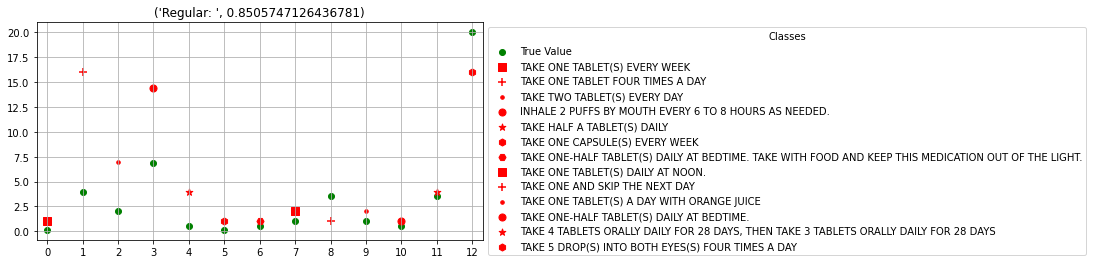

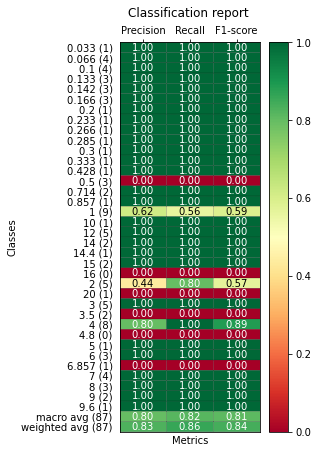

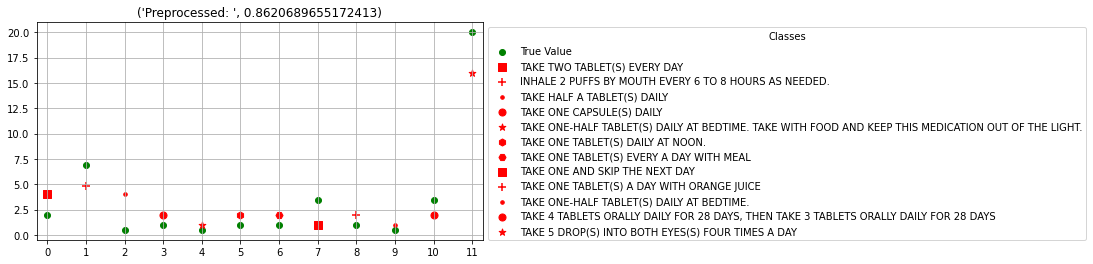

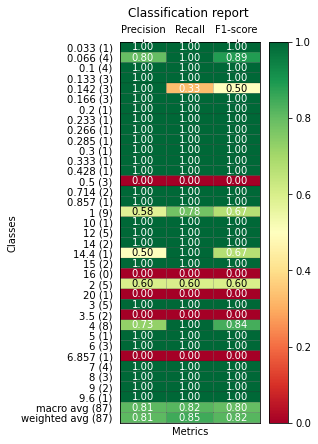

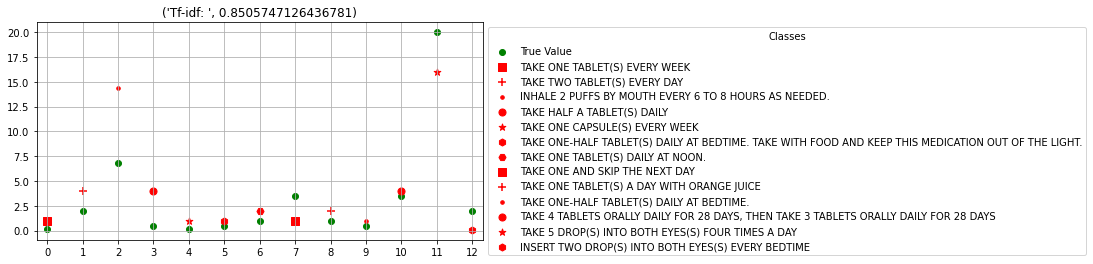

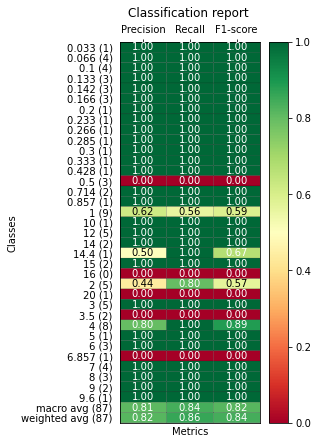

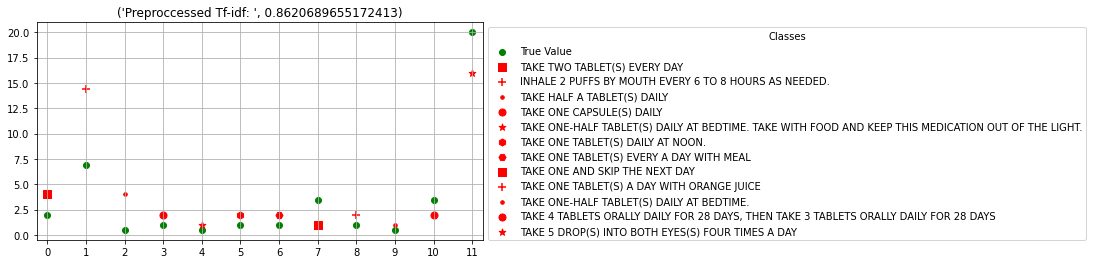

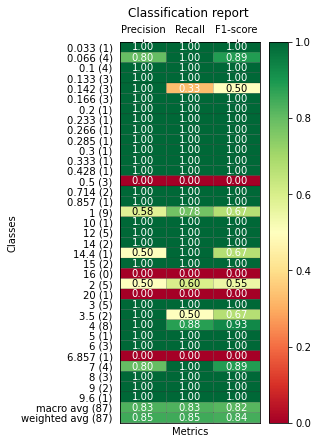

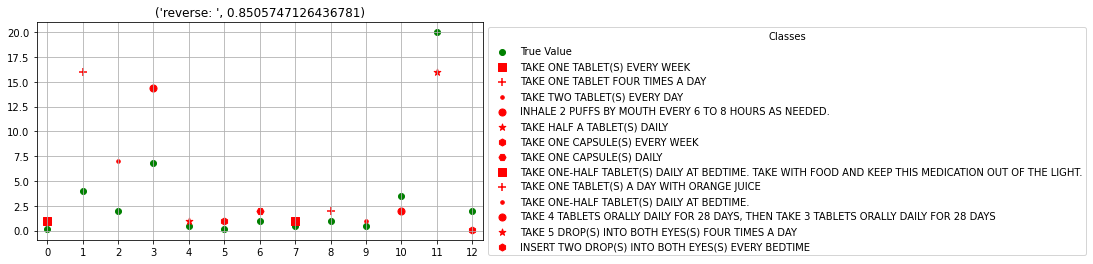

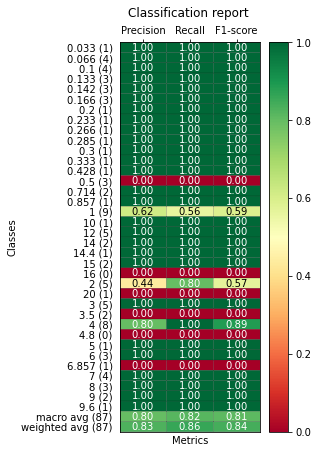

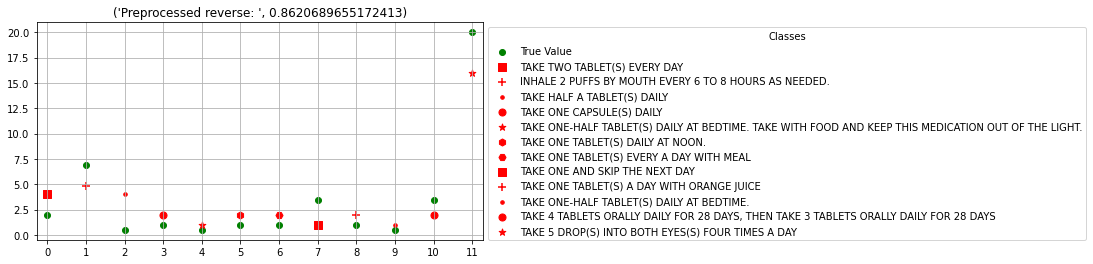

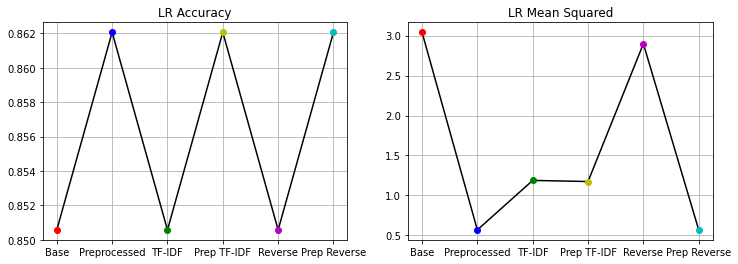

In [10]:
# Logistic Regression
LRs = [None] * 6
LRAccs = [None] * 6
LRMeanSquared = [None] * 6

log = LogisticRegression(C= 400, class_weight='balanced',dual= False,fit_intercept= False,
                        intercept_scaling=0.02,max_iter=1000, penalty= 'l2', random_state = 1)

#Baseline Logistic Regression
LRs[DEFAULT], LRAccs[DEFAULT], LRMeanSquared[DEFAULT] = train_model(log, X_train_counts, y_train, X_test_counts, y_test)
LMT= "Regular: ", LRAccs[DEFAULT]
plot(LRs[DEFAULT], X_train_counts, y_train, X_test_counts, y_test, X_test, LMT)

#Logistic Regression using Preprocessing
LRs[PREP], LRAccs[PREP], LRMeanSquared[PREP] = train_model(log, X_train_counts_pre, y_train, X_test_counts_pre, y_test)
pre_LMT = "Preprocessed: ", LRAccs[PREP]
plot(LRs[PREP], X_train_counts_pre, y_train, X_test_counts_pre, y_test, X_test, pre_LMT)


#Logistic Regression using tfidf
LRs[TFIDF], LRAccs[TFIDF], LRMeanSquared[TFIDF] = train_model(log, X_train_tfidf, y_train, X_test_tfidf, y_test)
tfidf_LMT = "Tf-idf: ", LRAccs[TFIDF]
plot(LRs[TFIDF], X_train_tfidf, y_train, X_test_tfidf, y_test, X_test, tfidf_LMT)

#Logistic Regression using tfidf and preprocessing
LRs[PREPTFIDF], LRAccs[PREPTFIDF], LRMeanSquared[PREPTFIDF] = train_model(log, X_train_pre_tfidf, y_train, X_test_pre_tfidf, y_test)
tfidf_pre_LMT = "Preproccessed Tf-idf: ", LRAccs[PREPTFIDF]
plot(LRs[PREPTFIDF],  X_train_pre_tfidf, y_train, X_test_pre_tfidf, y_test, X_test, tfidf_pre_LMT)


#Logistic Regression using reverse idf
LRs[REVERSE], LRAccs[REVERSE], LRMeanSquared[REVERSE] = train_model(log, X_train_ridf, y_train, X_test_ridf, y_test)
ridf_LMT = "reverse: ", LRAccs[REVERSE]
plot(LRs[REVERSE],  X_train_ridf, y_train, X_test_ridf, y_test, X_test, ridf_LMT)

#Logistic Regression using reverse idf with preprocessing
LRs[PREPREVERSE], LRAccs[PREPREVERSE], LRMeanSquared[PREPREVERSE] = train_model(log, X_train_pre_ridf, y_train, X_test_pre_ridf, y_test)
ridf_pre_LMT = "Preprocessed reverse: ", LRAccs[PREPREVERSE]
plot(LRs[PREPREVERSE],  X_train_pre_ridf, y_train, X_test_pre_ridf, y_test, X_test, ridf_pre_LMT)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)

plotAccuracies(LRAccs, title = "LR Accuracy", ax=ax1)
plotAccuracies(LRMeanSquared, title = "LR Mean Squared", ax=ax2)

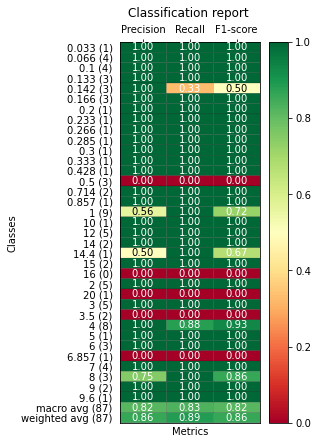

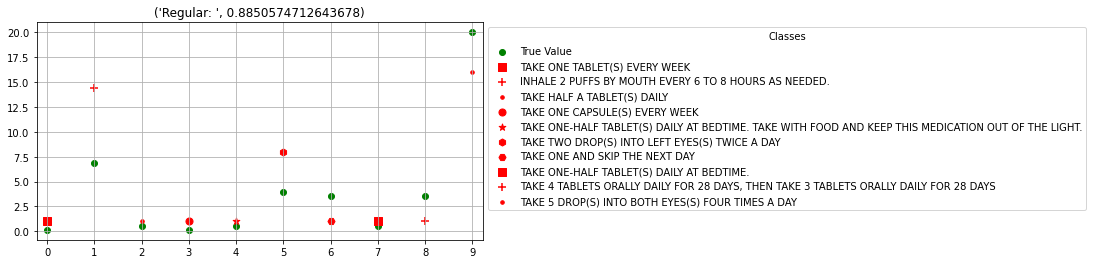

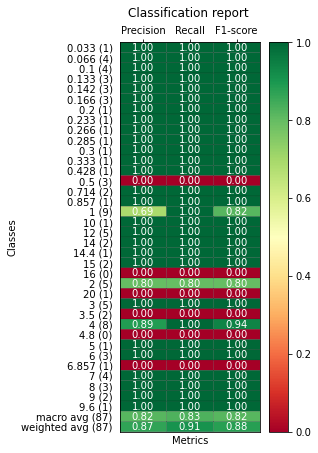

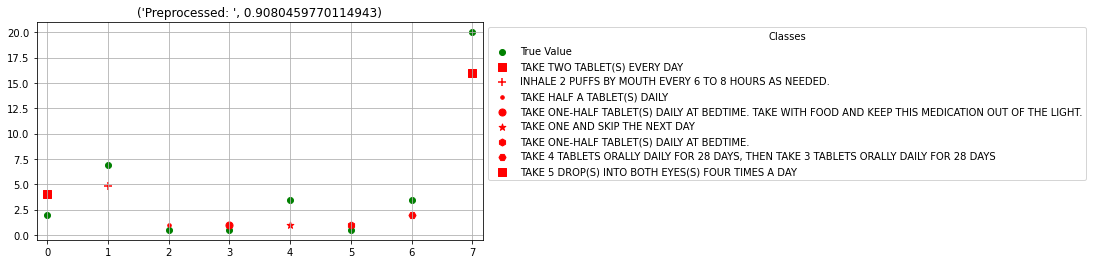

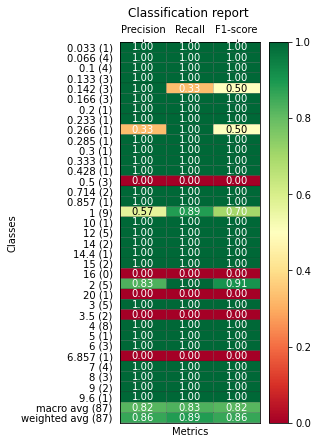

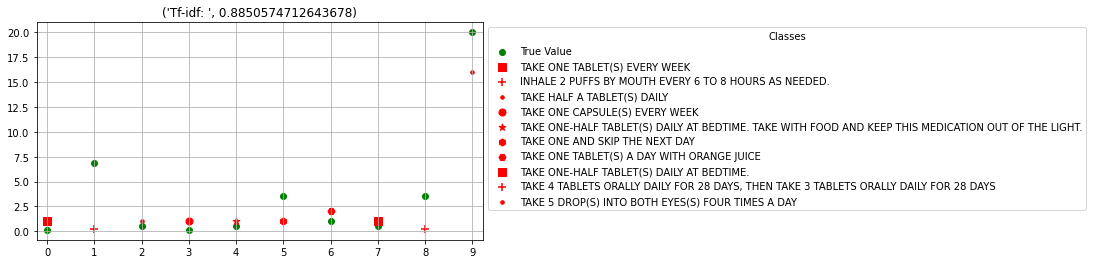

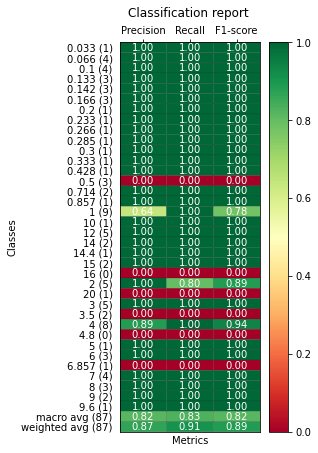

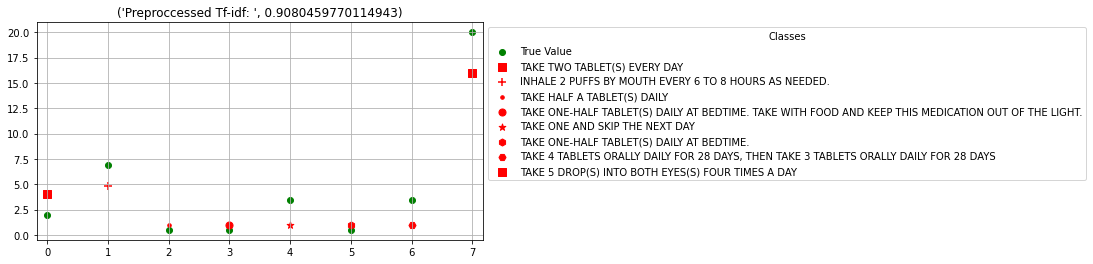

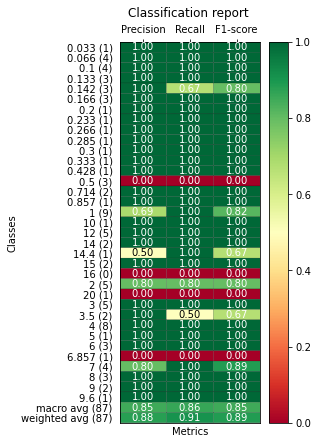

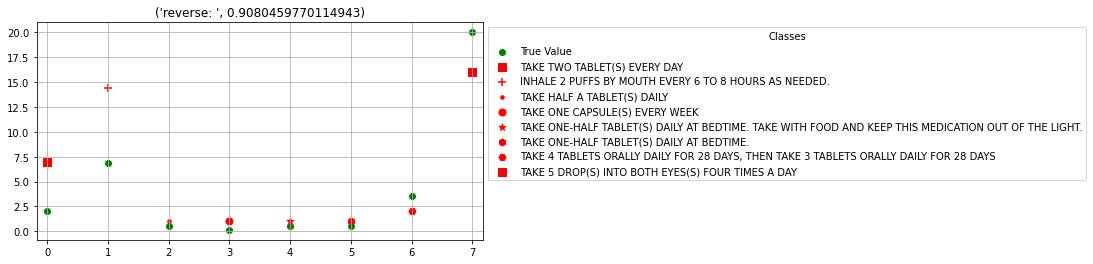

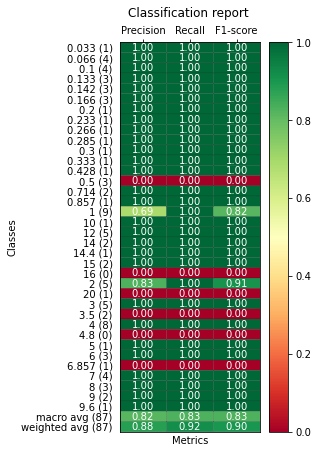

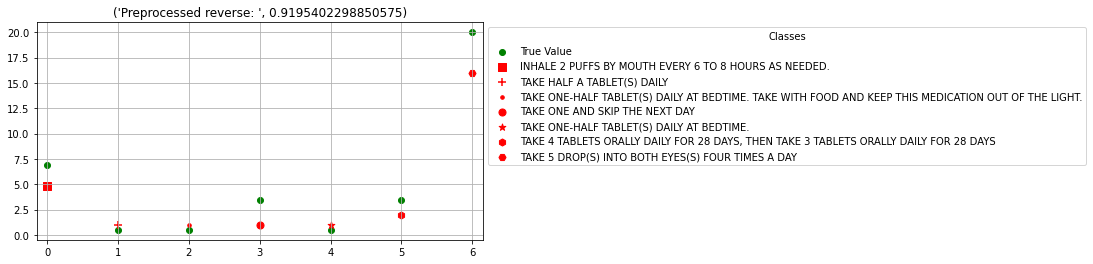

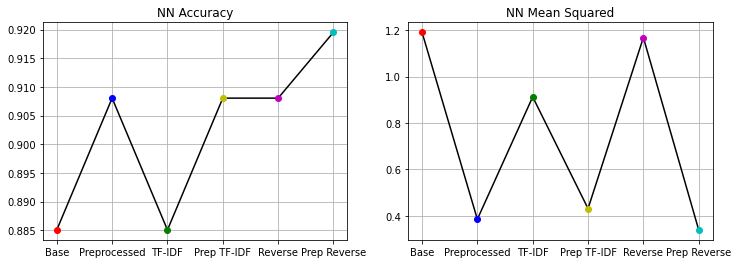

In [11]:
# Neural Network CLF
NNs = [None] * 6
NNAccs = [None] * 6
NNMeanSquared = [None] * 6

MLP = MLPClassifier(hidden_layer_sizes=((100),),activation='logistic', 
                     solver='lbfgs',momentum=0.09,verbose=False,
                   alpha= 0.001, beta_1= 0.01,beta_2= 0.999,max_iter=1000, random_state = 1)

#Neural Network baseline
NNs[DEFAULT], NNAccs[DEFAULT], NNMeanSquared[DEFAULT] = train_model(MLP, X_train_counts, y_train, X_test_counts, y_test)
NNT = "Regular: ", NNAccs[DEFAULT]
plot(NNs[DEFAULT], X_train_counts, y_train, X_test_counts, y_test, X_test, NNT)

#Neural Network with preprocessing
NNs[PREP], NNAccs[PREP], NNMeanSquared[PREP] = train_model(MLP, X_train_counts_pre, y_train, X_test_counts_pre, y_test)
pre_NNT = "Preprocessed: ", NNAccs[PREP]
plot(NNs[PREP], X_train_counts_pre, y_train, X_test_counts_pre, y_test, X_test, pre_NNT)


#Neural Network using tf-idf
NNs[TFIDF], NNAccs[TFIDF], NNMeanSquared[TFIDF] = train_model(MLP, X_train_tfidf, y_train, X_test_tfidf, y_test)
NNT_tfidf = "Tf-idf: ", NNAccs[TFIDF]
plot(NNs[TFIDF], X_train_tfidf, y_train, X_test_tfidf, y_test, X_test, NNT_tfidf)

#Neural Network using tf-idf and preprocessing
NNs[PREPTFIDF], NNAccs[PREPTFIDF], NNMeanSquared[PREPTFIDF] = train_model(MLP, X_train_pre_tfidf, y_train, X_test_pre_tfidf, y_test)
NNT_tfidf_pre = "Preproccessed Tf-idf: ", NNAccs[PREPTFIDF]
plot(NNs[PREPTFIDF],  X_train_pre_tfidf, y_train, X_test_pre_tfidf, y_test, X_test, NNT_tfidf_pre)


#Neural Network using reverse tf-idf
NNs[REVERSE], NNAccs[REVERSE], NNMeanSquared[REVERSE] = train_model(MLP, X_train_ridf, y_train, X_test_ridf, y_test)
NNT_reverse = "reverse: ", NNAccs[REVERSE]
plot(NNs[REVERSE],  X_train_ridf, y_train, X_test_ridf, y_test, X_test, NNT_reverse)

#Neural Network using reverse tf-idf and preprocessing
NNs[PREPREVERSE], NNAccs[PREPREVERSE], NNMeanSquared[PREPREVERSE] = train_model(MLP, X_train_pre_ridf, y_train, X_test_pre_ridf, y_test)
NNT_reverse_pre = "Preprocessed reverse: ", NNAccs[PREPREVERSE]
plot(NNs[PREPREVERSE],  X_train_pre_ridf, y_train, X_test_pre_ridf, y_test, X_test, NNT_reverse_pre)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)

plotAccuracies(NNAccs, title = "NN Accuracy", ax=ax1)
plotAccuracies(NNMeanSquared, title = "NN Mean Squared", ax=ax2)

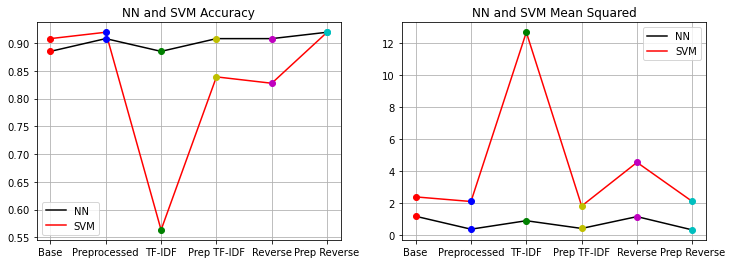

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
legends = ["NN", "SVM"]
plotAccuracies(NNAccs, title = "NN and SVM Accuracy", ax=ax1, accs2=SVMAccs, legends=legends)
plotAccuracies(NNMeanSquared, title = "NN and SVM Mean Squared", ax=ax2, accs2=SVMMeanSquared, legends=legends)

In [15]:
#Gridsearch, dont run
def grid(params, model, name):
    gs = GridSearchCV(model, params, cv=2, n_jobs=-1)
    gs = gs.fit(X_train_counts, y_train)
    
    print(name)
    for param_name in sorted(params.keys()):
        print("%s: %r" % (param_name, gs.best_params_[param_name]))

# parametersNB = {
#     'alpha': (0.5,1,2,3,4,5),
#     'fit_prior': (True,False),
# }
# grid(parametersNB,MultinomialNB(),"MNB" )

# parametersSVM = {
#     'C': (100,130,150,158,160,163,170,200,250,290,300,350),
#     'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
#     'gamma': ('scale', 'auto'),
# }
# grid(parametersSVM,svc,"SVC" )

# parametersRF = {
#     'n_estimators': (100,150),
#     'criterion': ('gini','entropy'),
#     'max_depth': (100,150),
#     'min_samples_split': (6,8),
#     'min_samples_leaf': (1,2),
#     'min_weight_fraction_leaf': (0,1),
#     'max_features': ('auto', 'sqrt', 'log2'),
#     'max_leaf_nodes': (0,10,50),
#     'min_impurity_decrease': (0,10,50),
#     'class_weight': ('balanced', 'balanced_subsample'),
#     'ccp_alpha': (0,2),
# }

# grid(parametersRF,RandomForestClassifier(),"RF" )
# parametersLR = {
#     'penalty': ('l1', 'l2', 'elasticnet', 'none'),
#     'dual': (True,False),
#     'C': (400,600,800),
#     'fit_intercept': (True,False),
#     'intercept_scaling': (0.02,0.05,0.07),
#     'class_weight': ('dict', 'balanced'),
#     'max_iter': (170, 200)
    
# }

# grid(parametersLR,LogisticRegression(),"LR" )

# parametersNN = {
#     'hidden_layer_sizes': ((10,),(100,),(150,)),
#     'activation': ('identity', 'logistic', 'tanh', 'relu'),
#     'solver': ('lbfgs', 'sgd', 'adam'),
#     'alpha': (0.00001, 0.0001,0.001,1),
#     'learning_rate': ('constant', 'invscaling', 'adaptive'),
#     'momentum': (0.01,0.09,0.9),
#     'beta_1': (0.01,0.09),
#     'beta_2': (0.01,0.999)  
# }

# grid(parametersNN,MLPClassifier(),"NN" )

In [16]:
#Gridsearch results

#Naive Bayes
# alpha: 0.5
# fit_prior: False

#Support Vector Machine Clasifier
# C: 1000
# gamma: 'auto'
# kernel: 'sigmoid'

# Random Forest
# ccp_alpha: 0
# class_weight: 'balanced'
# criterion: 'gini'
# max_depth: 150
# max_features: 'auto'
# max_leaf_nodes: 50
# min_impurity_decrease: 0
# min_samples_leaf: 1
# min_samples_split: 6
# min_weight_fraction_leaf: 0
# n_estimators: 100

# Logistic Regression
# C: 400
# class_weight: 'balanced'
# dual: False
# fit_intercept: False
# intercept_scaling: 0.02
# max_iter: 170
# penalty: 'l2'

# Nueral Network
# activation: 'logistic'
# alpha: 0.001
# beta_1: 0.01
# beta_2: 0.999
# hidden_layer_sizes: (100,)
# learning_rate: 'invscaling'
# momentum: 0.09
# solver: 'lbfgs'
